# SCS 3546 Week 2 - Model Tuning
In this module we will cover how we optimize and tune our neural network models. The content for this module is largely based on Chapter 11 from [Deep Learning](http://www.deeplearningbook.org) (Goodfellow, Bengio & Courville), and Chapter 10 (pages 272-276) from [Hands-On Machine Learning With Scikit-Learn & TensorFlow](http://shop.oreilly.com/product/0636920052289.do) (Geron).

## Table of Contents
1. [Learning Outcomes for this module](#learning-objectives)
2. [Key Topics for this module](#key-topic-overview)
3. [Background: Why tune neural networks](#why-tune-nns)
4. [Performance metrics](#performance-metrics)
5. [Baseline models](#baseline-models)
6. [Determining whether to gather more data](#more-data)
7. [Selecting hyperparameters](#selecting-hyperparameters)
    1. [Manual fine tuning of hyperparameters](#manual-tuning)
    2. [Automated tuning of hyperparameters](#automated-tuning)
        1. [Grid search](#grid-search)
        2. [Random search](#random-search)
        3. [Model-based hyperparameter optimization](#model-based-optimization)
8. [Debugging strategies](#debugging-strategies)
9. [Examples](#examples)
10. [References](#references)

In [1]:
from IPython.display import Image

### 1. Learning Outcomes for this module <a class="anchor" id="learning-objectives"></a>
- Gain an improved understanding of why and how neural networks are optimized
- Understand how performance is quantified for neural networks, and how this can be used to tune them
- Learn how to use manual and automated approaches for neural network parameter tuning

### 2. Topics for this module <a class="anchor" id="key-topic-overview"></a>
The key topics addressed in this module are:

* Why we tune neural networks
* How we evaluate neural network performance
* How we know when we need to add more data
* How hyperparameters are selected
* Manual and automated methods for hyperparameter tuning

### 3. Why tune neural networks? <a class="anchor" id="why-tune-nns"></a>

Neural networks can contain virtually any imaginable [topology](https://en.wikipedia.org/wiki/Network_topology) in principle, as well as any number of layers, any number of neurons per layer, multiple possible activation functions, weight initialization logic, etc. Each of these are known as [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) of the neural network, or parameters that are set before the learning process begins. 

Alteration of hyperparameters can greatly affect the performance and training time of a neural network. Successful application of neural networks requires more than selection of an appropriate algorithm, but also, the ability to improve the performance of a system through response to feedback. While this can seem complicated, correctly applying any machine learning algorithm simply requires following this design process:

* **Determine your goals, your error metric, and your target value for this error metric**: These should be driven by the problem you are trying to solve.
* **Establish a working end-to-end pipeline quickly**: this should include estimation of the appropriate performance metrics.
* **Instrument the system well to determine bottlenecks in performance**: You should be able to diagnose multiple components of the algorithm to determine which are performing worse than expected, and whether this is due to over or under fitting, or due to some other issue with the data or software.
* **Repeatedly make incremental changes**: These include gathering new data, adjusting parameters, or changing algorithms.

Each step in this process is focused on in detail below.


### 4. Performance metrics  <a class="ancor" id="performance-metrics"></a>

There are multiple methods of evaluating the performance of neural networks, the selection of which will depend on the context of the application. Before reviewing them however, it's important to understand that irrespective of evaluation metric, very few models will achieve zero error (if this is something you see, the mostly likely explanation is improper construction of the model). The [Bayes error](https://en.wikipedia.org/wiki/Bayes_error_rate) defines the minimum error rate that you can hope to achieve, even with an infinite amount of training data. Specifically, the Bayes error rate of the data distribution is the probability an instance is misclassified by a classifier that knows the true class probabilities given the predictors. The Bayes error is given by:

$$p = 1 - \sum_{i=1}^{L} \int_{C_{i}} P(c_{i})P(x|c_{i})dx $$

Where *L* is the number of classes, $P(c_{i})$ denotes the *a priori* class probability of class *i*, $P(x|c_{i})$ denotes the class likelihood, and $C_{i}$ is the region where class i has the highest posterior.

A useful acid test is to compare the performance of your model to previously published findings. Previously published results typically set the benchmark of what is attainable. Achieving results far greater than the existing comparators, while plausible, may be an indication of a poorly constructed model, and can often be met with skepticism. **An estimation of the desired error rate should be identified before model design** (whether based on the above formula, previous similar studies, or some other threshold). 

Another consideration is the type of error measurement to use (note that this is unrelated to the cost function of the algorithm). Before discussing these, it's worthwhile to review the concept of false positives and false negatives.

Finally, it is important to remember that a substantial drop-off in performance on a "test" dataset (as compared to a "validation" dataset) is a sign of over-fitting.

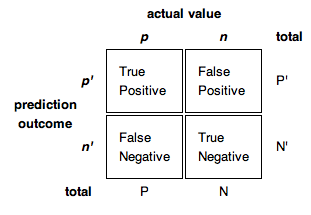

In [2]:
Image(filename='fp_fn.png')

For binary classifiers, common estimates of model performance are based on our observation of True Positives (TPs), False Positives (FPs), True Negatives (TNs), and False Negatives (FNs):

| Measurement                         | Formula        |
|-------------------------------------|----------------|
| Sensitivity/Recall/TPR              | TP / (TP + FN) | 
| Specificity/TNR                     | TN / (TN + FP) |
| Precision/Positive Predictive Value | TP / (TP + FP) |
| Negative Predictive Value           | TN / (TN + FN) |
| False Positive Rate                 | FP / (FP + TN) |
| False Discovery Rate                | FP / (FP + TP) |
| Accuracy                            | (TP + TN) / (TP + TN + FP + FN) |


Based on these formulas, we can see that simplistic measurements like Accuracy or Precision, may not always be useful on their own. 

**Example**: A test detects a rare form of cancer (incidence in the overall population is 1 in 1,000). However, the test is broken, and always just predicts a healthy patient. The table below shows the results seen when giving this test to 2,000 randomly selected people:

| | Have the disease | Don't have the disease |
|-|------------------|------------------------|
|Test Positive |        0         |            0           |
|Test Negative |        2         |          1998          |  

What is the Accuracy of this test? What is the Recall?

In [3]:
TP = 0.0
FP = 0.0
FN = 2.0
TN = 1998.0

acc = (TP + TN) / (TP + TN + FP + FN)
rec = TP / (TP + FN)

print("Accuracy is %.4f, Recall is %.4f" % (acc, rec))

Accuracy is 0.9990, Recall is 0.0000


Accuracy as a metric doesn't work well when we have unbalanced sets of negatives and positives in our data. Other metrics allow us to evaluate how well a model discriminates between classes without being as susceptible to bias. Two of the most prominent are the **Receiver Operating Characteristic** (ROC) curve, and the **Precision Recall** (PR) curve. 

*ROC Curve*<br>
The ROC curve visualizes how well the model discriminates between classes at varying levels of Specificity (see definition in table above). Typically, the area under this curve is calculated, with an area of 0.5 corresponding to our expectation for a random classifier, and 1.0 for a perfect classifier.

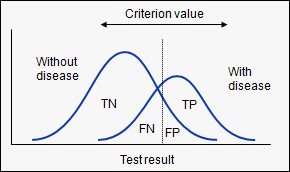

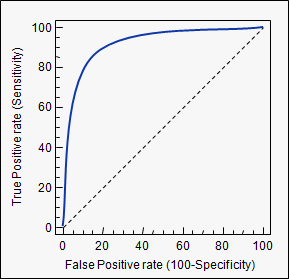

https://www.medcalc.org/manual/roc-curves.php


In [4]:
display(Image(filename='ROC_1.png'))
display(Image(filename='ROC_2.png'))
print("https://www.medcalc.org/manual/roc-curves.php")

While ROC curves do account for Specificity, they also assume an equal cost of False Positives and True Positives, which may not always be the case.

*PR Curve*<br>
Precision-Recall (PR) plots show us Precision values at a given True Positive Rate (Recall - see table above for definition of Precision and Recall). This makes them more appropriate for "needle-in-a-haystack" type of analyses such as the example presented above.|

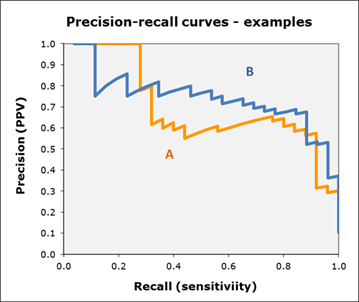

https://acutecaretesting.org/en/articles/precision-recall-curves-what-are-they-and-how-are-they-used


In [5]:
display(Image(filename='PR_1.png'))
print("https://acutecaretesting.org/en/articles/precision-recall-curves-what-are-they-and-how-are-they-used")

Typically we report a single value from a PR curve, such as the area under the curve (as for the ROC curve), Precision at a consistent Recall value (e.g. Precision at 20% recall), or the **F-score**, which is given by:
$$F = \frac{2pr}{p + r}$$

One other metric useful in evaluating a machine learning model is **coverage**. Coverage is the fraction of examples for which the machine learning system is able to produce a response. In some instances, the model may not be able to confidently classify an example, and there may be a trade-off to consider between the overall accuracy of the model, and the required coverage (e.g. higher coverage may be achieved at a lower overall accuracy).

Another important thing to keep in mind is that performance metrics need not be limited to those listed here, and can often be tailored based on the specific needs of a given project.

### 5. Default baseline models  <a class="ancor" id="baseline-models"></a>

Once you have a sense of the evaluation metrics you'd like to use, the next option should be the choice of machine learning method. While neural networks will allow you to solve a host of unique learning problems, they may be overkill for others. If your problem can be solved with a simple linear model, there may be no need to introduce unnecessary complexity. However, if your problem involves object recognition, speech recognition, translation, or something similar, it is often best to begin with a simple deep learning model, adding complexity based on performance.

Selection of deep learning model will depend on the nature of the problem addressed, for example:

| Type of Input | Suggested Model |
|------------------|------------------------|
| Fixed-size vectors | Feedforward network with fully connected layers |
| Known topological structure (e.g. images) | Convolutional nework |
| Sequence | Gated recurrent net (LSTM or GRU) |

**Selecting an optimization algorithm**<br>
Typically, a reasonable optimization algorithm for deep learning models is [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (SGD) with momentum and a decaying learning rate, although [Adam](https://arxiv.org/abs/1412.6980v8) (Kingma & Ba) shows superior results for many problems (you can see a quick video explaining the differences [here](https://www.coursera.org/lecture/deep-neural-network/adam-optimization-algorithm-w9VCZ)), and find a useful reference by Bottou [here](https://leon.bottou.org/publications/pdf/tricks-2012.pdf).

**Regularization**<br>
Regularization is a form of smoothing or regression that shrinks coefficient estimates towards zero, effectively discouraging the generation of a complex model in an effort to reduce over-fitting. This can be especially important when your training dataset is small. [Early stopping](https://en.wikipedia.org/wiki/Early_stopping), a form of regularization, sets a limit on the number of iterations to be run, and tends to work effectively in limiting over-fitting.


### 6. Determining whether to gather more data  <a class="ancor" id="more-data"></a>

Once your evaluation metric, model, and other associated methods are selected (your full end-to-end framework), it can be run and, potentially, improved. Your first inclination will likely be to alter some aspect of your end-to-end pipeline and examine the resulting effect on performance, but a reasonable first question is, would more data have helped?

If performance of your model on your training data is poor, it is likely that this training data is not being used effectively, so there may be little reason to collect additional data. In this case it may be beneficial to begin altering the model size (e.g. adding layers or units to each layer), adjusting the learning rate, etc. If none of these show any effect, quality of the training data may be the issue (too noisy, wrong inputs, etc), so collecting "better" data may be more of an immediate need that simply collecting more data.

Alternately, if the performance on the training set is good, but the performance on the test set is poor, gathering additional data should be highly effective in improving performance. If obtaining additional labeled data is feasible, this should be considered first. In some applications however adding data may not be possible, and so another alternative is to reduce the model size (e.g. adjusting the weight or decay coefficients) or adding/strengthening regularization. 

### 7. Selecting hyperparameters <a class="ancor" id="selecting-hyperparameters"></a>

A hyperparameter for a model typically has the following characteristics: 

1. It is external to the model itself, and can not be estimated by the model itself 
2. It is set before the model begins learning
3. It can be tuned to improve performance of the model

Hyperparameters can be selected either manually or in an automated way. If selecting them manually, the practitioner should have a good understanding of what they do and how they affect model performance. Automatic methods for hyperparameter selection typically require less knowledge of the function of these hyperparameters, but require additional computational time as they are often found through permutation. An overall description of both manual and automatic hyperparameter selection methods is described below.

### *7.1 Manual tuning* <a class="ancor" id="manual-tuning"></a>

The figure below highlights both over-fitting and generalization error [generalization error](https://en.wikipedia.org/wiki/Generalization_error). 

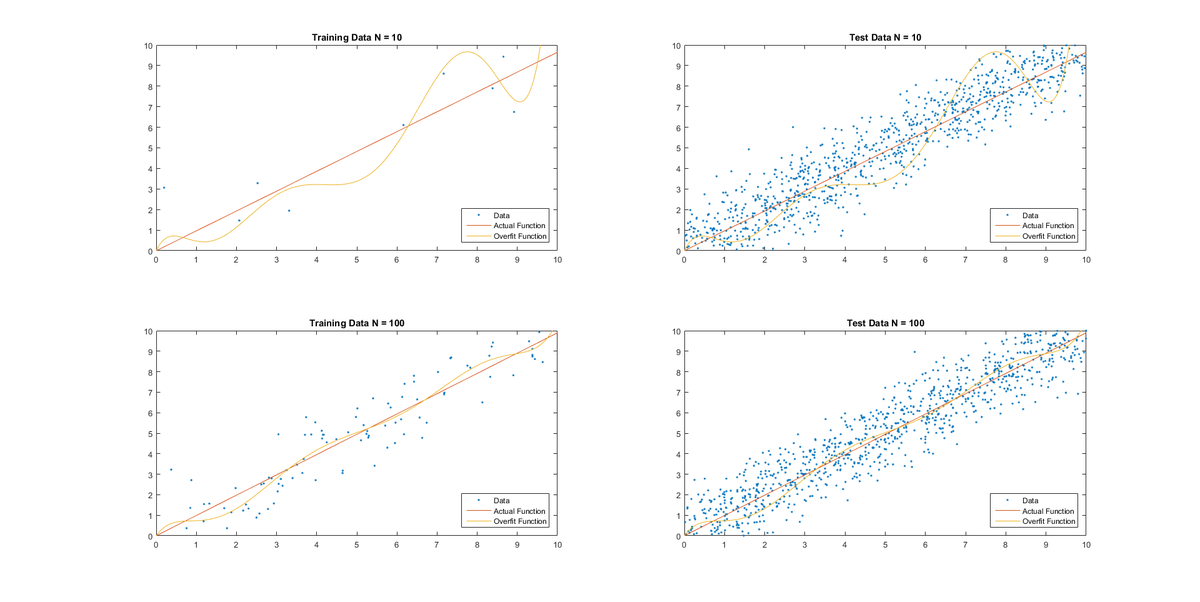

In [6]:
display(Image(filename='gen_error.png'))

https://en.wikipedia.org/wiki/Generalization_error#/media/File:RegressionOverfitting.png

The goal of manual tuning is to reduce the generalization error, adjusting the complexity of the model to match the complexity of the task, as evaluated based on external data. The ability of a model to contain complexity is known as its **capacity**. Model capacity is affected by three things:

1. The complexity of the model (e.g. adding hidden layers will increase model capacity)
2. The ability of the model to minimize the cost function
3. The degree to which the cost function and training method regularize the model

More intricate models will have greater capacity, but that capacity will result in over-fitting without appropriate cost and regularization functions. 

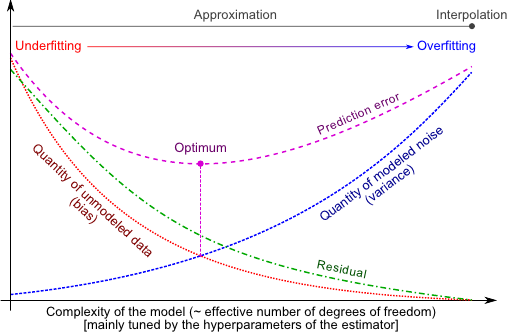

http://www.brnt.eu/phd/node14.html


In [7]:
display(Image(filename='gen_error2.png'))
print("http://www.brnt.eu/phd/node14.html")

As you've seen previously, generalization error tends to follow this same U-shaped pattern when plotted against the value of hyperparameters. One extreme corresponds to low capacity & high generalization error (under-fitting), while the other extreme corresponds to high capacity & also high generalization error (over-fitting). 

For some hyperparameters (e.g. number of hidden units in a layer), over-fitting occurs when the value is high, while for others over-fitting occurs when the value is low (e.g. weight decay coefficient). Additionally, some hyperparameters may be discrete or binary, and so may not be able to provide information on the entire curve. 

A summary of key tunable parameters is shown in the table below (adapted from Goodfellow, Bengio & Courville).

|Hyperparameter     |  Increases Capacity When | Reason     | Caveats|
|-------------------|--------------------------|------------|--------|
|Number of hidden units | Increased | Increasing the number of hidden units increases the representational capacity of the model | Increasing the number of hidden units increases both the time and memory cost of essentially every operation on the model|
|Learning rate | Tuned optimally | An improper learning rate, whether too high or too low, results in a model with low effective capacity due to optimization failure | |
|Convolution kernel width | Increased | Increasing the kernel width increases the number of parameters in the model. | A wider kernel results in a narrower output dimension, reducing model capacity unless you use implicit zero padding to reduce this effect. Wider kernels require more memory for parameter storage and increase runtime, but a narrower output reduces memory cost.|
|Implicitly zero padding | Increased | Adding implicit zeros before convolution keeps the representation size large. | Increases time and memory cost of most operations |
|Weight decay coefficient | Decreased | Decreasing the weight decay coefficient frees the model parameters to become larger | |
|Dropout rate | Decreased | Dropping units less often gives the units more opportunities to "conspire" with each other to fit the training set | |

Of these, **learning rate** is the most critical parameter, and should be the first modified if time/resources are limited. The relationship between learning rate and model capacity is complex, in that model capacity is highest when learning rate is *optimal*, not at its highest or lowest value. Determining this optimal value may require some trial and error, but is the recommended first step in improving model performance.

The remaining hyperparameters can be modified in the context of train, test, and target error. If your training error is higher than your target error, complexity of your model has to be increased (more layers, more nodes, remove regularization). If training error is low (i.e. below your target error rate) but test error is high, the goal of optimization should be to decrease the test error with as little as possible increase in the training error. The most effective way to achieve this is to reduce effective capacity of the model (e.g. adding [dropout](https://arxiv.org/abs/1207.0580) or weight decay (i.e. after each update, weights are multiplied by a factor slightly less than 1)). 

### *7.1 Automated tuning* <a class="ancor" id="automated-tuning"></a>

While neural networks can often perform well with only a few manually tuned hyperparameters, there could potentially be dozens of hyperparameters that can be optimized for a given problem. This is both a major advantage, and disadvantage of neural networks over other classes of algorithms. Often these adjustments can be incremental when beginning from a strong starting point, but it can be the case that default values are not known or can not be easily estimated. In these cases it is useful to have an automated method to identify these hyperparameter values. Note that this is in and of itself an optimization problem, and as such uses an objective function (i.e. budget, memory, etc). Below are some common methods for automated selection of hyperparameter values. For a more detailed review, see [Bergstra & Bengio (2012)](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf).

### 7.1.1 Grid search <a class="ancor" id="grid-search"></a>

When deciding on parameters, it would seem to be a good strategy to just systematically try combinations of parameters in a grid-like search. In a **grid search**, a small set of finite values are pre-selected covering the range of possible values of a given hyperparameter. These parameter combinations are then permuted, and the model evaluated. For example, for two parameters, you could try ten different values of each in a 10 x 10 grid. The pre-selection of hyperparameter values at regular intervals differentiates the grid search from a random search. Some notes about using a grid search:

- When performing a grid search, values are typically set on a logarithmic scale (e.g. 0.001, 0.01, 0.1, 1)
- When a "good" parameter value is identified, the grid size is typically contained and re-run, centered around the good parameter
- Due to the high computational cost, grid search typically is not optimal when there are more than 3 hyperparameters being optimized ($O(n^{m})$ for *m* parameters with *n* values

How many tests would you need to do to try 10 different values of a million parameters, not uncommon in a neural net?

### 7.1.2 Random search <a class="ancor" id="random-search"></a>

A less computationally expensive alternative to a grid search is a **random search**. In a random search, a marginal distribution is specified for each hyperparameter (e.g. Bernouli for binary variables). Hyperparameter values are then sampled from each distribution without any binning or discretizing. As for a grid search, once the hyperparameter values have been selected, the model is evaluated. Since multiple hyperparameter values are being modified simultaneously, random search tends to find effective solutions much more quickly than a grid search.

**Random search vs grid search**<br>
A schematic highlighting the differences between random and grid searches is shown below (originally from [Bergstra & Bengio (2012)](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf)).

In [ ]:
display(Image(filename='grid_vs_random.png'))

The figure above shows 9 trials of both a grid search (left) and random search (right) for values of 2 hyperparameters with low dimensionality. The grid search on the left uses three possible discritized values for each of the 2 hyperparameters, while the random search on the right uses no binning/discritization. The effect of each hyperparameter on model performance can be seen in the green (for the parameter on the x-axis) and the yellow (for the parameter on the y-axis) plots, with one parameter having a much greater impact on model performance (green or x-axis). In the 9 trials, the grid search only attempts 3 distinct values of any given hyperparameter, while the random search provides much more information on the location of an optimal value. 

### 7.1.3 Model-based hyperparameter optimization <a class="ancor" id="model-based-optimization"></a>

Tuning the hyperparameters of a neural network can be thought of as an optimization problem, where the cost function is the validation error, and the hyperparameters are the input values. Unfortunately, due to the nature of some hyperparameters (e.g. low dimensionality, low interactivity with the validation error), typical gradient calculations are generally not effective. As an alternative, a model can be generated of the validation error, and effect of various hyperparameters estimated. For example, a Bayesian regression model can be used to estimate both validation error, and the uncertainty in validation error, for a given hyperparameter value. While there are several notable tools for model-based hyperparameter optimization (see [Snoek et al](https://arxiv.org/pdf/1206.2944.pdf)), these should be applied with caution. In some instances, they can produce entirely inaccurate estimations. 

### 8. Debugging strategies <a class="ancor" id="debugging-strategies"></a>

When model performance is poor, it can often be difficult to determine if there was a bug in the code itself, or there was improper construction of the model. Similarly, unrealistically high performance may also indicate an error in the code or model setup that should be addressed. Further complementing this difficulty, machine learning models can be adaptive, meaning they can achieve reasonable performance even when one component of the model is broken. For these reasons, debugging strategies for neural networks typically either use a very simplified test case (where the outcome could be easily determined and verified), or test each of the individual components in isolation. 

These are important tasks to consider when debugging a neural network model:

- **Visualize the model output:** Select a random subset of model predictions and manually examine for accuracy. If possible, identify where the model misclassified inputs and examine if this was due to a systematic error.
- **Fit a small and/or well-characterized dataset:** If model performance is difference than that expected, it's possible a software or implementation issue is the cause. It's often useful to use a simplified implementation of your model to verify that results match your expectation.

### 9. Examples <a class="ancor" id="examples"></a>

**Example 1:** Tuning Batch Size & Number of Epochs (based on tutorial found <a href="https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/">here</a>)

In [ ]:
# Load libraries
import numpy as np
from keras import models
from keras import layers
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from datetime import datetime


print(str(datetime.now()))

# Set random seed
np.random.seed(0)

# Number of features
number_of_features = 10

# Generate features matrix and target vector
features, target = make_classification(n_samples = 10000,
                                       n_features = number_of_features,
                                       n_informative = 3,
                                       n_redundant = 0,
                                       n_classes = 2,
                                       weights = [.5, .5],
                                       random_state = 0)

# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = models.Sequential()
    model.add(layers.Dense(12, input_dim=number_of_features, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(features, target)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print(str(datetime.now()))

Comparative random search of the same parameter space

In [ ]:
print(str(datetime.now()))
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid)
grid_result = grid.fit(features, target)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print(str(datetime.now()))

**Example 2:** Tuning learning rate and momentum

In [ ]:
print(str(datetime.now()))
# Function to create model, required for KerasClassifier
def create_model(learn_rate=0.01, momentum=0):
    # create model
    model = models.Sequential()
    model.add(layers.Dense(12, input_dim=number_of_features, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile model
    optimizer = optimizers.SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)

# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(features, target)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print(str(datetime.now()))

Comparative random search of the same parameter space

In [ ]:
print(str(datetime.now()))
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid)
grid_result = grid.fit(features, target)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print(str(datetime.now()))

**Example 3:** Tune multiple parameters simultaneously

In [ ]:
print(str(datetime.now()))
# Create function returning a compiled network
def create_network(optimizer='rmsprop'):
    
    # Start neural network
    network = models.Sequential()

    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=16, activation='relu', input_shape=(number_of_features,)))

    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=16, activation='relu'))

    # Add fully connected layer with a sigmoid activation function
    network.add(layers.Dense(units=1, activation='sigmoid'))

    # Compile neural network
    network.compile(loss='binary_crossentropy', # Cross-entropy
                    optimizer=optimizer, # Optimizer
                    metrics=['accuracy']) # Accuracy performance metric
    
    # Return compiled network
    return network

# Wrap Keras model so it can be used by scikit-learn
neural_network = KerasClassifier(build_fn=create_network, verbose=0)

# Create hyperparameter space
epochs = [5, 10]
batches = [5, 10, 100]
optimizers_list = ['rmsprop', 'adam']

# Create hyperparameter options
hyperparameters = dict(optimizer=optimizers_list, epochs=epochs, batch_size=batches)

# Create grid search
grid = GridSearchCV(estimator=neural_network, param_grid=hyperparameters)

# Fit grid search
grid_result = grid.fit(features, target)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print(str(datetime.now()))

# Create random search
rando = RandomizedSearchCV(estimator=model, param_distributions=param_grid)

# Fit random search
rando_result = rando.fit(features, target)

# Summarize results
print("Best: %f using %s" % (rando_result.best_score_, rando_result.best_params_))
means = rando_result.cv_results_['mean_test_score']
stds = rando_result.cv_results_['std_test_score']
params = rando_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print(str(datetime.now()))

### 9. References <a class="ancor" id="references"></a>

1. Bergstra, Bengio (2012) *Random Search for Hyper-Parameter Optimization*, Journal of Machine Learning Research, 13:281-305.
2. Bottou (2012) *Stochastic Gradient Descent Tricks*, In: Montavon G., Orr G.B., Müller KR. (eds) Neural Networks: Tricks of the Trade. Lecture Notes in Computer Science, vol 7700. Springer, Berlin, Heidelberg.
3. Geron, Aurelien (2017) *Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems*. O'Reilly Media, Inc.
4. Goodfellow, Bengio, Courville (2016) *Deep Learning*. Boston, Massachusetts: MIT Press.
5. Kingma, Ba (2014) *Adam: A Method for Stochastic Optimization*, ArXiv, arXiv:1412.6980v8.
6. Snoek, Larochelle, Adams (2012) *Practical Bayesian Optimization of Machine Learning Algorithms*, ArXiv, arXiv:1206.2944.